In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Section 1: Load and Initial Exploration
# ============================================
# Load the data from the specified file path
file_path = '/Users/arkamandol/DataspellProjects/Desertation_arka_23023023/data_files/UK_Police_Street_Crime_2018-10-01_to_2021_09_31.csv'
df = pd.read_csv(file_path)

# Display the initial rows of the dataset to understand its structure
df.head()

,Unnamed: 0,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,0,c7000c41002f19263d4adec66b911f1c3f5e7eeb1302a3...,2020-01,West Yorkshire Police,West Yorkshire Police,-1.570572,53.607792,On or near Park/Open Space,E01007418,Barnsley 016A,Other theft,Status update unavailable,NaN
1,1,b8bc1b6cf423a9431734982fffb11f803cf82140702cc7...,2020-01,West Yorkshire Police,West Yorkshire Police,-1.670108,53.553629,On or near Huddersfield Road,E01007426,Barnsley 027D,Robbery,Investigation complete; no suspect identified,NaN
2,2,8c69cefea36edafe5fa3f992ccc31d3cfd0c9af9a81429...,2020-01,West Yorkshire Police,West Yorkshire Police,-1.879031,53.943807,On or near Cross End Fold,E01010646,Bradford 001A,Bicycle theft,Investigation complete; no suspect identified,NaN
3,3,7236a8fb307214df61ca7a9b93bd309c0524f9bee58d89...,2020-01,West Yorkshire Police,West Yorkshire Police,-1.882746,53.933807,On or near Cocking Lane,E01010646,Bradford 001A,Burglary,Investigation complete; no suspect identified,NaN
4,4,92803cebdfde14ad870899c45c6bee398331f33a053bf1...,2020-01,West Yorkshire Police,West Yorkshire Police,-1.881467,53.944510,On or near Kilners Croft,E01010646,Bradford 001A,Criminal damage and arson,Investigation complete; no suspect identified,NaN


In [3]:
# 1. Remove any rows where 'Longitude' or 'Latitude' values are missing
df_cleaned = df.dropna(subset=['Longitude', 'Latitude'])

# 2. Focus the dataset on "Violence and sexual offences" crimes
df_cleaned = df_cleaned[df_cleaned['Crime type'] == "Violence and sexual offences"]

# 3. Keep only the necessary columns for analysis
columns_to_keep = ['Month', 'Longitude', 'Latitude']
df_cleaned = df_cleaned[columns_to_keep]

In [4]:
# Convert the 'Month' column to datetime format for time series analysis
data = df_cleaned.copy()
data['Month'] = pd.to_datetime(data['Month'])

# Set the 'Month' column as the index
data.set_index('Month', inplace=True)

# Aggregate the data to get the number of crimes per month
monthly_crime_count = data.resample('M').size()

# Display the first few entries of the aggregated data
monthly_crime_count.head()

/var/folders/nt/vmygtqvs10vb28qdjwspykv00000gn/T/ipykernel_47974/2752920476.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_crime_count = data.resample('M').size()


Month
2018-10-31    155135
2018-11-30    147287
2018-12-31    144133
2019-01-31    148395
2019-02-28    140271
Freq: ME, dtype: int64

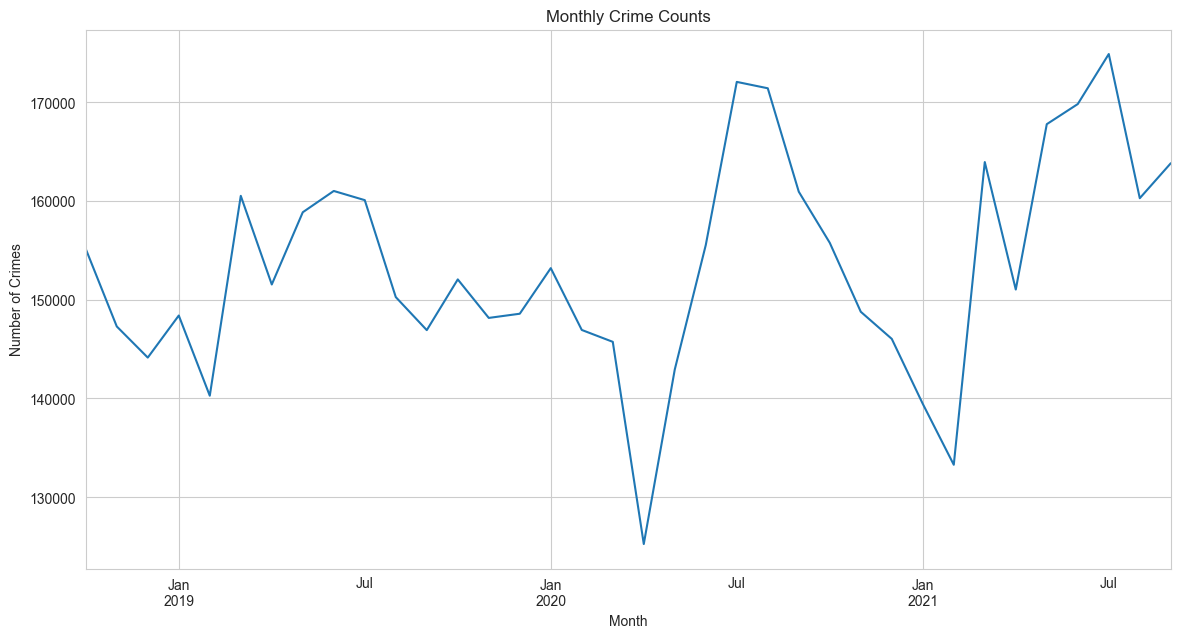

In [5]:
# Generate a line plot to visualize monthly crime counts over time
plt.figure(figsize=(14, 7))
monthly_crime_count.plot()
plt.title('Monthly Crime Counts')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.show()

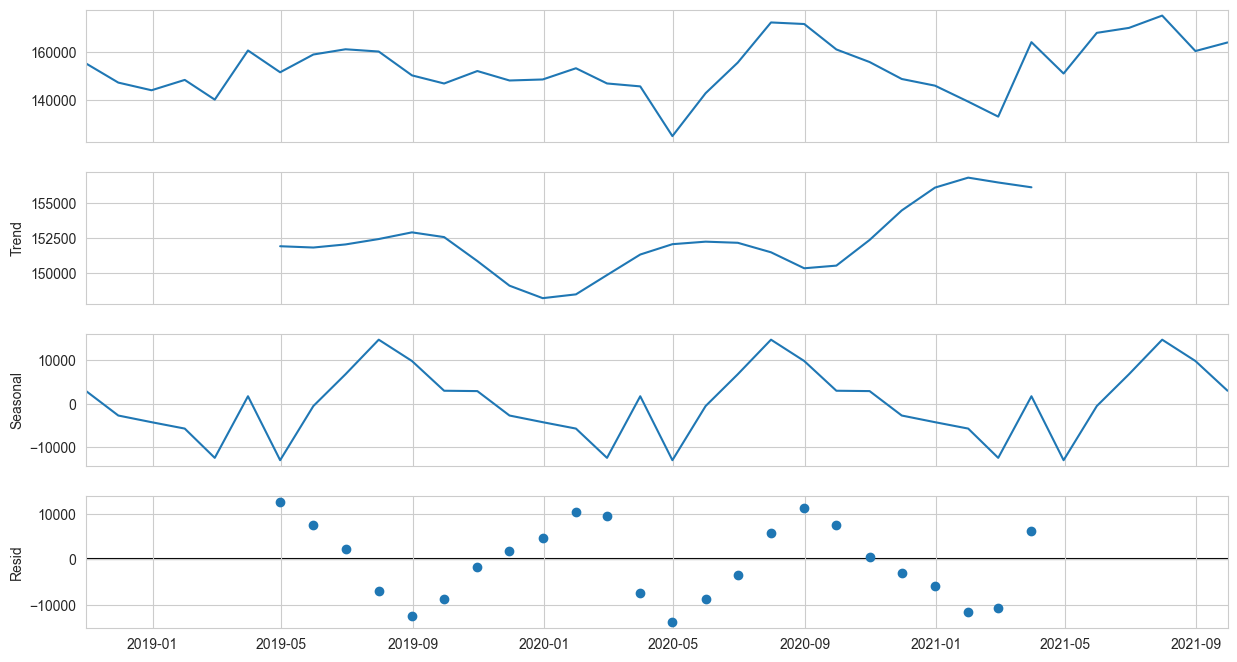

In [6]:
# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(monthly_crime_count, model='additive')

# Plot the decomposed components to better understand the underlying patterns
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()


In [7]:
# for Saving the cleaned and aggregated data to a new CSV file if needed
# save_path = '/Users/arkamandol/DataspellProjects/Desertation_arka_23023023/data_files/Cleaned_UK_Police_Street_Crime.csv'
# df_cleaned.to_csv(save_path, index=False)
# monthly_crime_count.to_csv(save_path)


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt

# Convert the series to a supervised learning dataset
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Reshape the data into a format suitable for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(monthly_crime_count.values.reshape(-1, 1))

# Create sequences of 12 months (1 year)
time_step = 12
X, Y = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and testing sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Define the LSTM model with dropout
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.1))  # Adding dropout after the first LSTM layer
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.1))  # Adding dropout after the second LSTM layer
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, batch_size=1, epochs=500)

# Predict using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform([Y_train])
Y_test = scaler.inverse_transform([Y_test])

# Calculate MSE, RMSE and MAE for training and testing data
train_mse = mean_squared_error(Y_train.T, train_predict)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(Y_train.T, train_predict)
test_mse = mean_squared_error(Y_test.T, test_predict)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(Y_test.T, test_predict)

print(f'Train MSE: {train_mse}')
print(f'Train RMSE: {train_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MSE: {test_mse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test MAE: {test_mae}')

# Predict the next 6 months (October 2021 to March 2022)
future_steps = 6
future_predictions = []
last_sequence = X[-1]  # The last sequence of the test set

for _ in range(future_steps):
    next_pred = model.predict(last_sequence.reshape(1, time_step, 1))
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

# Inverse transform future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate date range for predictions
last_date = monthly_crime_count.index[-1]
future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=future_steps, freq='M')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(monthly_crime_count.index, monthly_crime_count.values, label='Original Data', color='blue')
plt.plot(monthly_crime_count.index[time_step:time_step + len(train_predict)], train_predict,
         label='Training Predictions', color='orange')
plt.plot(monthly_crime_count.index[time_step + len(train_predict):time_step + len(train_predict) + len(test_predict)],
         test_predict, label='Testing Predictions', color='green')
plt.plot(future_dates, future_predictions, label='Future Predictions (Oct 2021 - Mar 2022)', color='red')

plt.title('LSTM Model Predictions vs. Actual Data')
plt.xlabel('Time')
plt.ylabel('Crime Count')
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7)
plt.legend()

# Set the x-ticks to be all months in the range
plt.gca().set_xticks(pd.date_range(start=monthly_crime_count.index[0], end=future_dates[-1], freq='M'))

# Format the x-ticks to show month and year
plt.gca().set_xticklabels([date.strftime('%Y-%m') for date in
                           pd.date_range(start=monthly_crime_count.index[0], end=future_dates[-1], freq='M')])

plt.show()


AttributeError: module 'tensorflow._api.v2.compat.v2.__internal__' has no attribute 'register_load_context_function'

In [ ]:
import numpy as np
from lime import lime_tabular
import matplotlib.pyplot as plt

# Assuming 'model' is your trained LSTM model and 'X_train', 'X_test' are prepared as described

def lstm_predict(input_data):
    """ Wrapper function to adapt input data for the LSTM model's expected input shape """
    reshaped_data = input_data.reshape(input_data.shape[0], time_step, 1)  # Reshape to [samples, time steps, features]
    return model.predict(reshaped_data)

# Reshape X_train for LIME
X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[1])

# Initialize the LIME Explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_2d,
    feature_names=['t-' + str(i) for i in range(X_train.shape[1])],  # Create feature names for each time step
    mode='regression'
)

# Loop through each instance in X_test
lime_explanations = []

for i in range(X_test.shape[0]):
    # Reshape test instance to 2D for LIME
    test_instance = X_test[i].reshape(1, -1)[0]

    # Generate explanation for the current instance
    exp = explainer.explain_instance(
        data_row=test_instance,
        predict_fn=lstm_predict,
        num_features=12  # Set this to ensure all features are considered
    )

    lime_explanations.append(exp)

    # Optionally, print or plot each explanation
    print(f"Explanation for instance {i}:")
    exp.show_in_notebook(show_table=True, show_all=False)

    # Plotting each explanation
    features, weights = zip(*[(i[0], i[1]) for i in exp.local_exp[0]])
    features = [f"t-{X_train.shape[1] - idx}" for idx in features]

    plt.figure(figsize=(10, 5))
    plt.bar(features, weights, color='skyblue')
    plt.xlabel('Features (Time Steps)')
    plt.ylabel('Weights')
    plt.title(f'LIME Feature Contributions for Instance {i}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


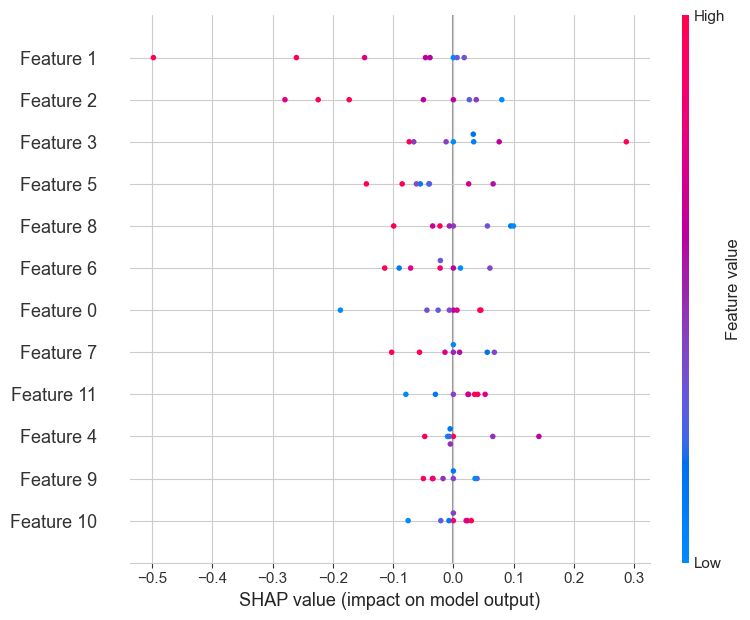

In [14]:
import shap
import numpy as np

# Define a custom prediction function that reshapes the input before predicting
def predict_reshaped(data):
    reshaped_data = data.reshape(data.shape[0], -1, 1)
    return model.predict(reshaped_data)

# Use a small subset of your training data as background for KernelExplainer
background = X_train.reshape(X_train.shape[0], -1)  # Flatten to 2D for KernelExplainer

# Initialize KernelExplainer with the custom predict function
explainer = shap.KernelExplainer(predict_reshaped, background)

# Compute SHAP values for your test set (reshaped to 2D)
X_test_2d = X_test.reshape(X_test.shape[0], -1)  # Flatten to 2D
shap_values = explainer.shap_values(X_test_2d, nsamples=100)

# Reshape SHAP values from (8, 12, 1) to (8, 12)
shap_values_reshaped = np.array(shap_values).reshape(X_test.shape[0], X_test.shape[1])

# Now use SHAP's summary plot, passing in the original X_test without the last dimension
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1])  # Remove the last dimension
shap.summary_plot(shap_values_reshaped, X_test_reshaped)
